# IS 4487 Lab 10

## Outline

Repeat exercises from Lab 9, but with the *Air Quality Daily AQI* dataset.

Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

Your target variable is *CATEGORY*, indicating if the air is healthy.  You can focus on either the entire country, split the country in regions, or focus on just one area (ex. Utah).   You can reduce noise by aggregating the data to the month of season level.   

Can you predict the category based on the location and time of year?  

The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the air quality dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
df = pd.read_csv (r'/content/daily_aqi_by_county_2023.zip')

Mounted at /content/gdrive


In [3]:
df.describe()

,State Code,County Code,AQI,Number of Sites Reporting
count,185017.000000,185017.000000,185017.000000,185017.000000
mean,29.936773,81.188415,43.498397,1.878595
std,15.904884,93.001539,23.905791,2.273400
min,1.000000,1.000000,0.000000,1.000000
25%,17.000000,23.000000,31.000000,1.000000
50%,30.000000,59.000000,41.000000,1.000000
75%,42.000000,107.000000,50.000000,2.000000
max,80.000000,810.000000,1695.000000,33.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185017 entries, 0 to 185016
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   State Name                 185017 non-null  object
 1   county Name                185017 non-null  object
 2   State Code                 185017 non-null  int64 
 3   County Code                185017 non-null  int64 
 4   Date                       185017 non-null  object
 5   AQI                        185017 non-null  int64 
 6   Category                   185017 non-null  object
 7   Defining Parameter         185017 non-null  object
 8   Defining Site              185017 non-null  object
 9   Number of Sites Reporting  185017 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 14.1+ MB


## Prepare Data

➡️ Assignment Tasks
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI

In [10]:
# create columns

# Create dummy variables
dummy_variables = pd.get_dummies(df['Defining Parameter'])
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
print(df_with_dummies)

       State Name county Name  State Code  County Code       Date  AQI  \
0         Alabama     Baldwin           1            3 2023-01-10   35   
1         Alabama     Baldwin           1            3 2023-01-11   28   
2         Alabama     Baldwin           1            3 2023-01-12   23   
3         Alabama     Baldwin           1            3 2023-01-13   18   
4         Alabama     Baldwin           1            3 2023-01-14   20   
...           ...         ...         ...          ...        ...  ...   
185012    Wyoming      Weston          56           45 2023-06-26   46   
185013    Wyoming      Weston          56           45 2023-06-27   50   
185014    Wyoming      Weston          56           45 2023-06-28   48   
185015    Wyoming      Weston          56           45 2023-06-29   47   
185016    Wyoming      Weston          56           45 2023-06-30   48   

       Category Defining Parameter Defining Site  Number of Sites Reporting  \
0          Good              PM2

In [13]:
# Add months to columns
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Add season to columns
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

print(df)

       State Name county Name  State Code  County Code       Date  AQI  \
0         Alabama     Baldwin           1            3 2023-01-10   35   
1         Alabama     Baldwin           1            3 2023-01-11   28   
2         Alabama     Baldwin           1            3 2023-01-12   23   
3         Alabama     Baldwin           1            3 2023-01-13   18   
4         Alabama     Baldwin           1            3 2023-01-14   20   
...           ...         ...         ...          ...        ...  ...   
185012    Wyoming      Weston          56           45 2023-06-26   46   
185013    Wyoming      Weston          56           45 2023-06-27   50   
185014    Wyoming      Weston          56           45 2023-06-28   48   
185015    Wyoming      Weston          56           45 2023-06-29   47   
185016    Wyoming      Weston          56           45 2023-06-30   48   

       Category Defining Parameter Defining Site  Number of Sites Reporting  \
0          Good              PM2

In [16]:
# Get rid of outliers and nulls
df_clean = df[(df['AQI'] < 600)]

df_clean = df_clean.dropna()

In [17]:
df_clean.describe()

,State Code,County Code,AQI,Number of Sites Reporting,Month
count,185012.000000,185012.000000,185012.000000,185012.000000,185012.000000
mean,29.937420,81.189285,43.470888,1.878462,4.251827
std,15.904612,93.002623,23.216058,2.273143,2.170640
min,1.000000,1.000000,0.000000,1.000000,1.000000
25%,17.000000,23.000000,31.000000,1.000000,3.000000
50%,30.000000,59.000000,41.000000,1.000000,4.000000
75%,42.000000,107.000000,50.000000,2.000000,6.000000
max,80.000000,810.000000,597.000000,33.000000,10.000000


In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185012 entries, 0 to 185016
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   State Name                 185012 non-null  object        
 1   county Name                185012 non-null  object        
 2   State Code                 185012 non-null  int64         
 3   County Code                185012 non-null  int64         
 4   Date                       185012 non-null  datetime64[ns]
 5   AQI                        185012 non-null  int64         
 6   Category                   185012 non-null  object        
 7   Defining Parameter         185012 non-null  object        
 8   Defining Site              185012 non-null  object        
 9   Number of Sites Reporting  185012 non-null  int64         
 10  Month                      185012 non-null  int64         
 11  Season                     185012 non-null  object  

In [19]:
#select final columns for use

columns_to_keep = ['Month','AQI','State Name','Season']
df_keep = df_clean[columns_to_keep]

In [20]:
df_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185012 entries, 0 to 185016
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Month       185012 non-null  int64 
 1   AQI         185012 non-null  int64 
 2   State Name  185012 non-null  object
 3   Season      185012 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.1+ MB


## Create Regression

➡️ Assignment Tasks
- Create a simple linear regression to predict AQI based on as many variables as you can use or derive.
- Visualize the regression with at least one of the variables

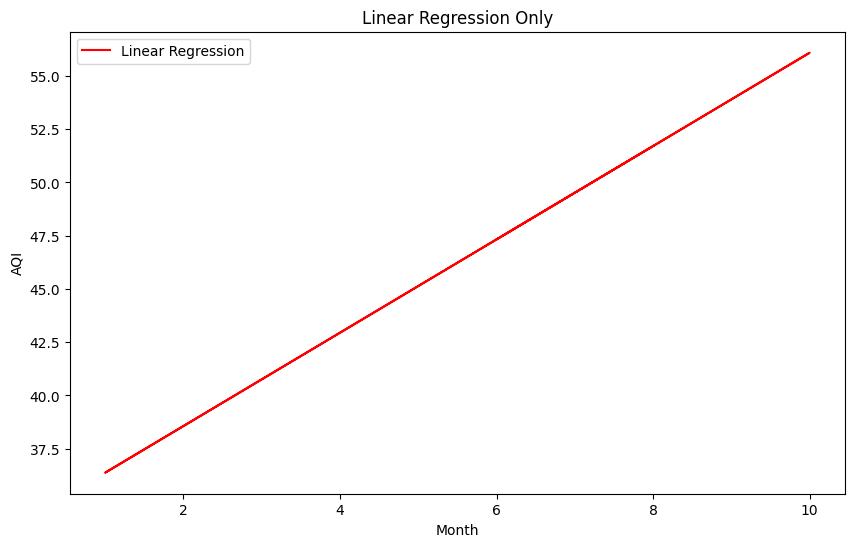

In [25]:
# create regression

X = df_keep[['Month']]
y = df_keep['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(X_train, y_pred_train, color='red', label='Linear Regression')

plt.xlabel('Month')
plt.ylabel('AQI')
plt.title('Linear Regression Only')
plt.legend()

plt.show()

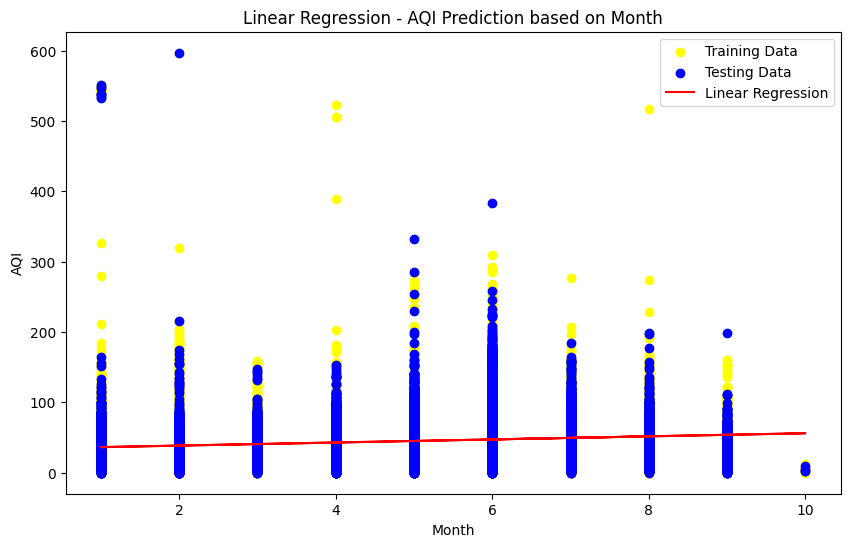

In [26]:
#visual

plt.figure(figsize=(10, 6))
# Making the scatterplot
plt.scatter(X_train, y_train, color='yellow', label='Training Data')
plt.scatter(X_test, y_test, color='blue', label='Testing Data')

# Add regression line
plt.plot(X_train, y_pred_train, color='red', label='Linear Regression')

plt.xlabel('Month')
plt.ylabel('AQI')
plt.title('Linear Regression - AQI Prediction based on Month')
plt.legend()

plt.show()

## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in the month of January?  

In [27]:
predicted_aqi_january = model.predict(np.array([[1]]))

print("Predicted AQI for the month of January:", predicted_aqi_january[0])

Predicted AQI for the month of January: 36.37272198955293


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from a year 20 years prior, using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [ ]:
#import, append and create new model